In [63]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
import random

In [69]:
lr = 1e-4
n_epochs = 25
batch_size = 32
noise_dim = 32
img_dim = 28 * 28 * 1
hidden_size = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [70]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [71]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, img_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [72]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        return self.model(flattened)

In [73]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optim_g = optim.Adam(generator.parameters(), lr=lr)
optim_d = optim.Adam(discriminator.parameters(), lr=lr)

criterion = nn.BCELoss()

Epoch [1/25], Step [100/1875], D Loss: 0.9916, G Loss: 0.7267
Epoch [1/25], Step [200/1875], D Loss: 0.7748, G Loss: 1.1795
Epoch [1/25], Step [300/1875], D Loss: 0.1687, G Loss: 3.0432
Epoch [1/25], Step [400/1875], D Loss: 0.3155, G Loss: 2.2248
Epoch [1/25], Step [500/1875], D Loss: 0.3987, G Loss: 2.1309
Epoch [1/25], Step [600/1875], D Loss: 0.1890, G Loss: 3.0919
Epoch [1/25], Step [700/1875], D Loss: 0.1123, G Loss: 3.6129
Epoch [1/25], Step [800/1875], D Loss: 0.1043, G Loss: 3.2091
Epoch [1/25], Step [900/1875], D Loss: 0.1384, G Loss: 3.1072
Epoch [1/25], Step [1000/1875], D Loss: 0.1787, G Loss: 3.0826
Epoch [1/25], Step [1100/1875], D Loss: 0.1604, G Loss: 4.0054
Epoch [1/25], Step [1200/1875], D Loss: 0.0375, G Loss: 4.1177
Epoch [1/25], Step [1300/1875], D Loss: 0.0605, G Loss: 4.0954
Epoch [1/25], Step [1400/1875], D Loss: 0.0622, G Loss: 3.8167
Epoch [1/25], Step [1500/1875], D Loss: 0.0945, G Loss: 3.8554
Epoch [1/25], Step [1600/1875], D Loss: 0.0290, G Loss: 4.9168
E

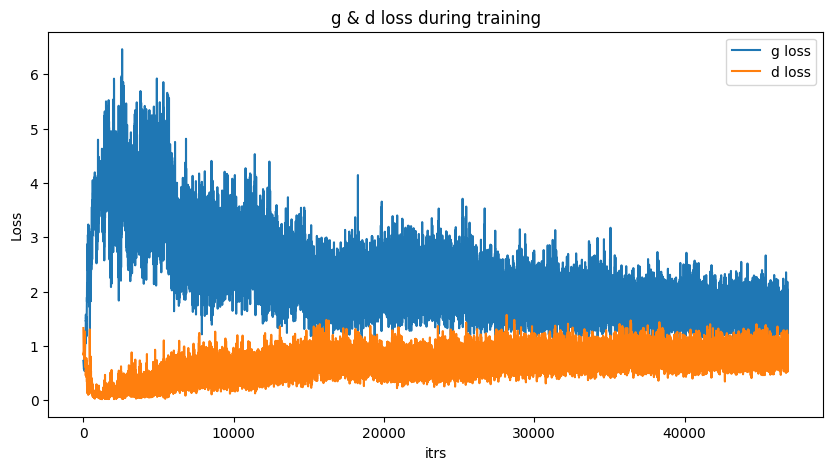

In [74]:
d_losses = []
g_losses = []
random.seed(1)
for epoch in range(n_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        current_batch_size = real_images.size(0)

        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        real_images = real_images.to(device)
        real_images = real_images.view(current_batch_size, -1)

        optim_d.zero_grad()

        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        z = torch.randn(current_batch_size, noise_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())  
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optim_d.step()

        optim_g.zero_grad()

        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()

        optim_g.step()
        d_loss = d_loss_real + d_loss_fake
        d_losses.append(d_loss.item())

        g_loss = criterion(outputs, real_labels)
        g_losses.append(g_loss.item())

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{len(train_loader)}], '
                  f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

print('Training finished.')

plt.figure(figsize=(10, 5))
plt.title("g & d loss during training")
plt.plot(g_losses, label="g loss")
plt.plot(d_losses, label="d loss")
plt.xlabel("itrs")
plt.ylabel("Loss")
plt.legend()
plt.show()

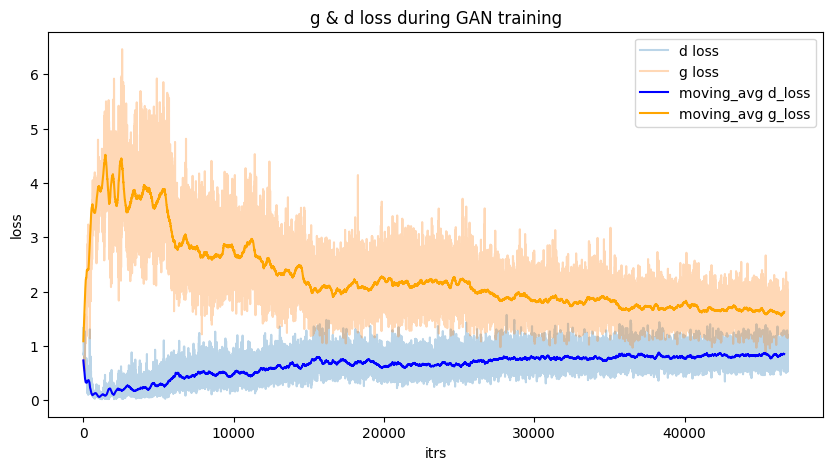

In [75]:
def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)

window_size = 250 
d_losses_moving_avg = moving_average(d_losses, window_size)
g_losses_moving_avg = moving_average(g_losses, window_size)

plt.figure(figsize=(10, 5))
plt.title("g & d loss during GAN training")

plt.plot(d_losses, label="d loss", alpha=0.3)
plt.plot(g_losses, label="g loss", alpha=0.3)

plt.plot(d_losses_moving_avg, label="moving_avg d_loss", color="blue")
plt.plot(g_losses_moving_avg, label="moving_avg g_loss", color="orange")

plt.xlabel("itrs")
plt.ylabel("loss")
plt.legend()
plt.show()
